In [1]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np  
import sigpy as sp
import sigpy.plot as pl
from sigpy.mri import radial
import sigpy.mri as mr

In [2]:
def show_image(image):
    plt.figure()
    plt.imshow(np.abs(image), cmap='gray')
    plt.show()

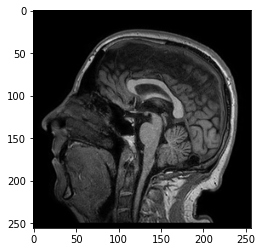

In [17]:
## Get the middle slice of image
sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)
img = t1[1][0][45]

show_image(img)

(128, 256, 2)


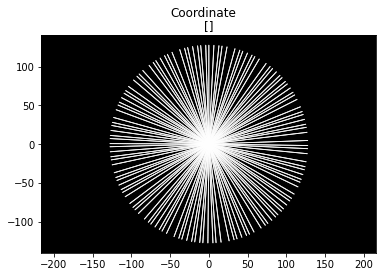

In [21]:
## Task 1 
# Generate and plot radical coordinate with acceleration factor
af = 2
coord = sp.mri.radial([int(256/af),256,2],[256,256])

print(coord.shape)
pl.ScatterPlot(coord, title='Coordinate')

In [22]:
## Task 2 Implement Quality Assessment
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

def evaluate(img,img_recon):
    img = (img - img.min())/(img.max() - img.min())*255
    img_recon = (img_recon - img_recon.min())/(img_recon.max() - img_recon.min())*255

    psnr = peak_signal_noise_ratio(img,abs(img_recon),data_range=img.max()-img.min())
    ssim_value = ssim(img, img_recon, data_range=img_recon.max()-img_recon.min())
    mse = mean_squared_error(img, abs(img_recon))

    
    print("PSNR = {}".format(psnr))
    print("SSIM = {}".format(ssim_value))
    print("MSE = {}".format(mse))
    print(" ")

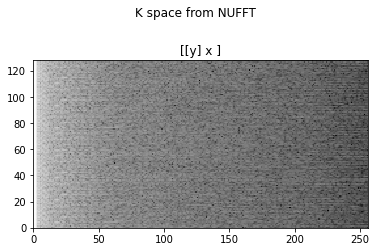

In [57]:
## Task 3 Reconstruction with the non-uniform Fourier transform (NUFT)

# Generate k-space from image by Non-uniformed fft 
img = img.astype('float64')
ksp_nu = sp.nufft(img, coord)
pl.ImagePlot(ksp_nu, mode = 'l', title= "K space from NUFFT")

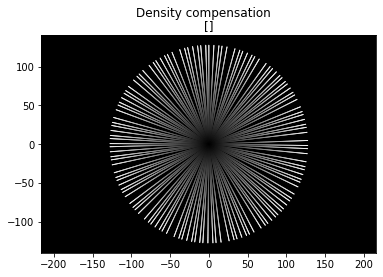

(128, 256)

In [55]:
# Create density compensation
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
pl.ScatterPlot(coord, dcf, title='Density compensation')
dcf.shape

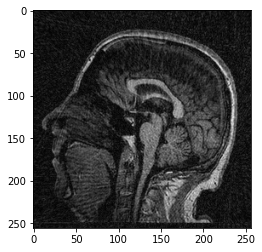

In [58]:
# Reconstruct by NUFT with DCF
img_recon_dcf = sp.nufft_adjoint(ksp_nu * dcf, coord, oshape=img.shape)
show_image(img_recon_dcf)

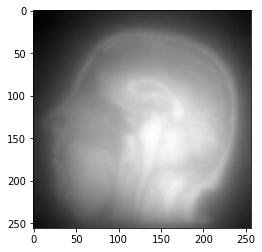

In [59]:
# Reconstruct by NUFT without DCF
img_recon = sp.nufft_adjoint(ksp_nu, coord, oshape=img.shape)
show_image(img_recon)

Evaluate reconstructed image with 64 spikes
PSNR = 14.378435928418208
SSIM = 0.41498445270376616
MSE = 2372.6668801598107
 
Evaluate reconstructed image with 128 spikes
PSNR = 16.166905680504502
SSIM = 0.48257183393772923
MSE = 1571.7728865388342
 


/opt/anaconda3/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:199: ComplexWarning: Casting complex values to real discards the imaginary part
  im2 = im2.astype(float_type, copy=False)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Evaluate reconstructed image with 256 spikes
PSNR = 21.768649797674072
SSIM = 0.6222459946609575
MSE = 432.7283822485797
 
Evaluate reconstructed image with 512 spikes
PSNR = 25.281744243892526
SSIM = 0.6656388000082555
MSE = 192.71074772001387
 
Evaluate reconstructed image with 1024 spikes
PSNR = 29.34900393272763
SSIM = 0.7120546877567984
MSE = 75.54051957046302
 


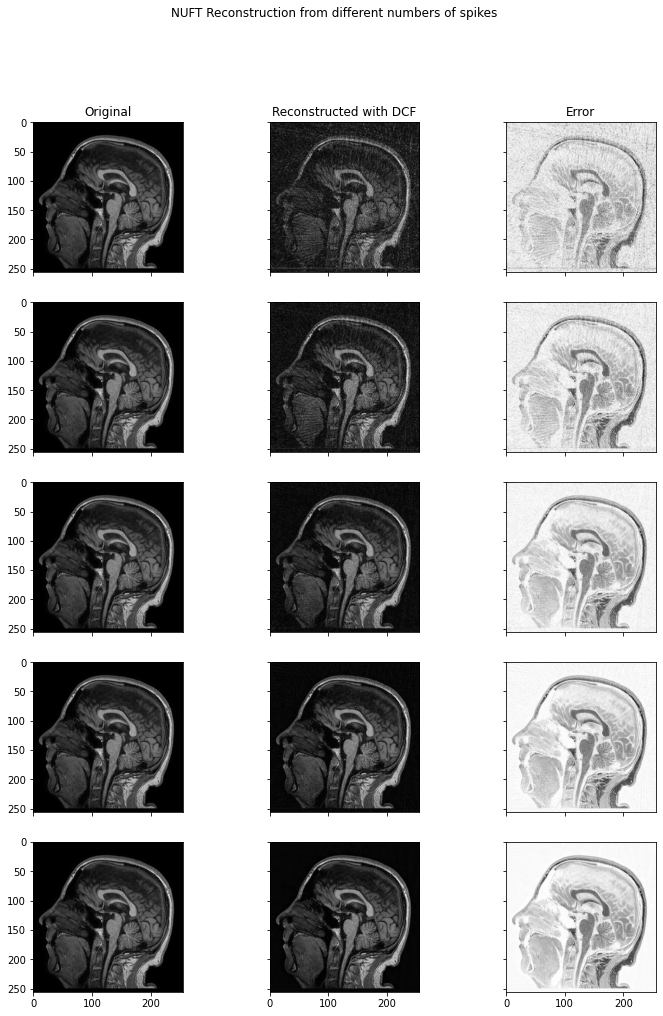

In [60]:
## Test with different numbers of spikes
from quality_assess import evaluate
num = [64, 128, 256, 512, 1024]
fig, ax = plt.subplots(nrows=len(num), ncols=3, figsize=(12,16),sharex=True, sharey=True)
fig.suptitle('NUFT Reconstruction from different numbers of spikes')
ax[0, 0].set_title('Original')
ax[0, 1].set_title('Reconstructed with DCF')
ax[0, 2].set_title('Error')


for i in range(len(num)):
    coord_test = sp.mri.radial([num[i],256,2],[256,256])
    ksp_nu = sp.nufft(img, coord_test)
    dcf = (coord_test[..., 0]**2 + coord_test[..., 1]**2)**0.5
    img_recon_dcf = sp.nufft_adjoint(ksp_nu * dcf, coord_test, oshape=img.shape)
    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 1].imshow(np.abs(img_recon_dcf), cmap='gray')
    ax[i, 2].imshow(img - np.abs(img_recon_dcf),cmap='gray' )
    print("Evaluate reconstructed image with {} spikes".format(num[i]))
    evaluate(img, img_recon_dcf)
plt.show()